# <center> Обучение с учителем. Классификация
## <center> Деревья решений в sklearn

In [ ]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики

import warnings # для игнорирования предупреждений
#Игнорируем предупреждения
warnings.filterwarnings('ignore')


# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn')

Работать будем с теми же данными о диабете:

In [ ]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


Ранее мы уже выбрали два признака, наиболее коррелирующих с целевой переменной: Glucose и BMI. Давайте вспомним, как выглядит диаграмма рассеяния, разделённая по цвету целевой переменной — признаком наличия диабета (Outcome):

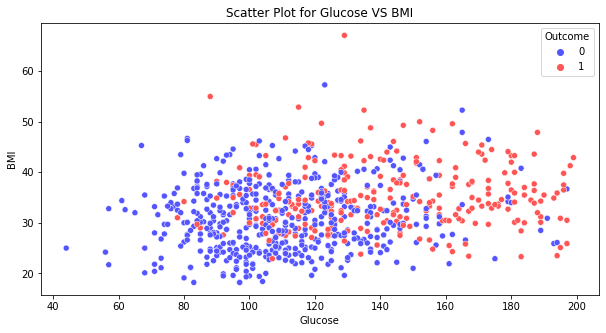

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графику
ax.set_title('Scatter Plot for Glucose VS BMI');

Создадим матрицу наблюдений `X` из признаков Glucose и BMI и столбец с правильными ответами `y` из признака Outcome:

In [ ]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

Будем решать задачу классификации пациентов с помощью дерева решений.

Модель дерева решений, его модификаций, а также функции для работы с деревьями находятся в модуле `tree` библиотеки sklearn. Импортируем его:

In [ ]:
from sklearn import tree #модели деревьев решения

Модель дерева решений для задачи классификации реализована в классе `DecisionTreeClassifier`. Этот класс реализует обучение по алгоритму CART.

Основные параметры `DecisionTreeClassifier`:

* `criterion` — критерий информативности (`'gini'` — критерий Джини и `'entropy'` — энтропия Шеннона).
* `max_depth` — максимальная глубина дерева (по умолчанию — `None`, глубина дерева не ограничена).
* `max_features` — максимальное число признаков, по которым ищется лучшее разбиение в дереве (по умолчанию — `None`, то есть обучение производится на всех признаках). Нужно потому, что при большом количестве признаков будет «дорого» искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков.
* `min_samples_leaf` — минимальное число объектов в листе (по умолчанию — 1). У этого параметра есть понятная интерпретация: если он равен 5, то дерево будет порождать только те решающие правила, которые верны как минимум для пяти объектов.
* `random_state` — параметр, отвечающий за генерацию случайных чисел.

Давайте обучим дерево решений с критерием информативности `criterion='entropy'` (энтропия Шеннона), максимальной глубиной `max_depth=3` и параметром `random_state=42`.

За обучение, как всегда, отвечает метод `fit()`. Данный метод реализует построение дерева решений по алгоритму CART, который мы рассматривали выше (алгоритм немного оптимизирован разработчиками `sklearn`, но смысл ровно тот же).

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=3, 
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

Итак, мы обучили дерево решений. Обученное дерево можно визуализировать в виде графа, чтобы посмотреть, как дерево делает предсказание. Для этого есть функция [plot_tree()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) из модуля tree.

Основные параметры функции:

* `decision_tree` — объект обученного дерева решений,
* `feature_names` — названия факторов,
* `class_names` — названия классов,
* `filled` — добавлять ли расцветку вершин графа.

Вызовем эту функцию:

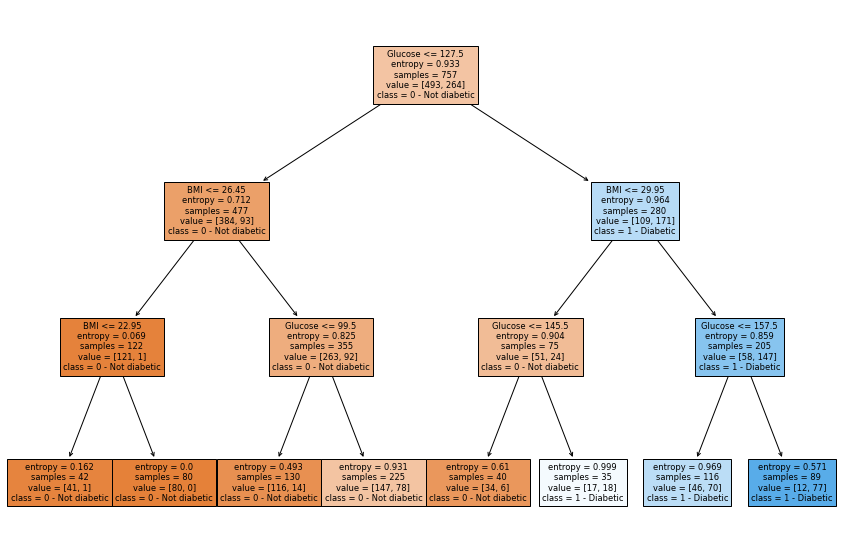

In [ ]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree_graph = tree.plot_tree(
    dt_clf_2d, #объект обученного дерева
    feature_names=X.columns, #названия факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #названия классов
    filled=True, #расцветка графа
);

В каждой из вершин записана следующая информация:

* предикат, по которому происходит разбиение;
* entropy — значение энтропии в текущей выборке;
* samples — количество объектов;
* values — количество объектов каждого из классов;
* class — преобладающий класс, на основе которого будет сделано предсказание.

**Как такое дерево будет делать предсказание?**

Например, появился новый пациент с концентрацией глюкозы 180 мг/100 мл и индексом массы тела 51 $кг/м^2$. Мы хотим вычислить вероятность наличия/отсутствия диабета у такого пациента.

«Прогоняем» характеристики пациента через предикаты в вершинах графа. Если предикат равен `True`, то идём по левому ребру вглубь графа, а если `False` — по правому.

1. `[Glucose <= 127.5] = False`. Переходим в правую вершину.

2. `[BMI <= 29.49] = False`. Переходим в правую вершину.

3. `[Glucose <= 157.5] = False`. Переходим в правую вершину.

4. Мы добрались до листовой вершины, которая соответствует объектам класса 1 — Diabetic. Значит, дерево определит данного пациента как больного диабетом.

    Вероятность наличия диабета в данном листе равна $77/(12+77)=0.865$.

    Вероятность отсутствия диабета: $12/(12+77)=0.135$.

Описанные выше операции дерево производит автоматически с помощью функции `predict()`, предназначенной для предсказания класса объекта.

In [ ]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = dt_clf_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

И `predict_proba()` — для предсказания вероятности принадлежности к каждому из классов:

In [ ]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

Давайте посмотрим, как будет выглядеть разделяющая поверхность дерева решений для двух признаков. Для этого воспользуемся функцией `plot_probabilities_2d()`, которую мы представляли в прошлом юните:

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


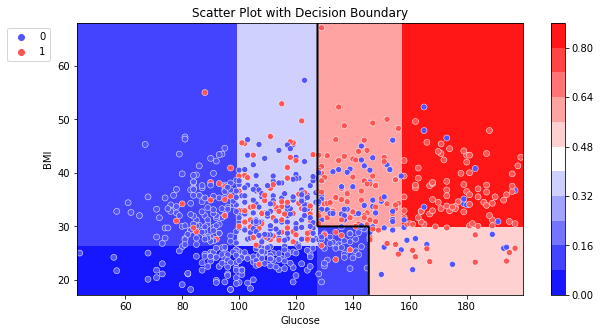

In [ ]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку.
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 10, cmap='bwr')
    #Рисуем разделяющую плоскость — линия, где вероятность равна 0.5.
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

plot_probabilities_2d(X, y, dt_clf_2d)

Как и ожидалось, дерево решений разделило пространство на множество прямоугольных частей, каждая из которых соответствует определённому листу дерева.

Количество этих областей равно количеству листьев — 8.

> **Примечание.** Так как вероятности в двух областях практически совпадают, на тепловой карте разница незаметна, области сливаются в одну и вы видите семь областей.

Попробуйте самостоятельно сопоставить построенное пространство с графом дерева решений, который мы построили выше.

Каждая часть пространства также соответствует определённой вероятности наличия диабета. Отследить её можно с помощью цветовой панели.

Чёрным обозначена граница, где вероятность наличия диабета равна 0.5. Точки, находящиеся правее этой разделяющей границы, относятся деревом к классу 1, а находящиеся левее, — к классу 0.

Теперь вернитесь в юнит по логистической регрессии и сравните то, как дерево решений и логистическая регрессия делят пространство факторов на части.

Можно рассчитать полученные метрики качества. Для этого предскажем наличие диабета для всех пациентов из матрицы наблюдений `X`, а затем рассчитаем метрики классификации с помощью функции `classification_report()` из библиотеки `sklearn`:

In [ ]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_2d.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       493
           1       0.69      0.62      0.65       264

    accuracy                           0.77       757
   macro avg       0.75      0.74      0.74       757
weighted avg       0.77      0.77      0.77       757



> Если вы сравните данный отчёт с полученным ранее для логистической регрессии, обученной на двух признаках, то увидите, что даже с небольшой глубиной 3 дерево решений решает задачу классификации лучше, чем логистическая регрессия.

Давайте построим дерево решений без ограничения его максимальной глубины. Для этого нам просто не нужно задавать параметр `max_depth`:

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART без ограничения его глубины
dt_clf_bad.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Сделаем предсказание:

In [ ]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_bad.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       493
           1       1.00      0.97      0.98       264

    accuracy                           0.99       757
   macro avg       0.99      0.98      0.99       757
weighted avg       0.99      0.99      0.99       757



Как выросли метрики! Мы практически идеально решаем задачу предсказания наличия диабета. Задача, над которой бьются медики всего мира, решается простейшим алгоритмом машинного обучения с потрясающей точностью! Причём для диагностики нам достаточно всего двух признаков — уровня глюкозы и индекса массы тела.

> Не кажется ли вам, что здесь что-то не так?

Давайте визуализируем граф (осторожно, код может выполняться в течение нескольких десятков секунд):

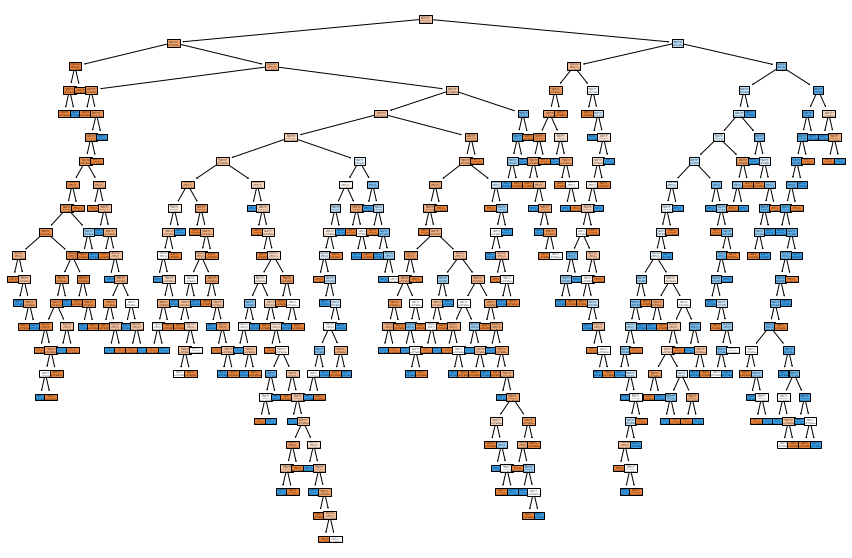

In [ ]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree_graph = tree.plot_tree(
    dt_clf_bad, #объект обученного дерева
    feature_names=X.columns, #названия факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #названия классов
    filled=True, #расцветка графа
);

Абсолютный хаос. Дерево задаёт огромное количество вопросов для того, чтобы предсказать правильный диагноз для каждого пациента из набора данных. Дерево настолько глубокое, что даже не помещается на экране.

> **Примечание**. Посмотреть получившуюся глубину дерева можно с помощью метода `get_depth()`:

In [ ]:
dt_clf_bad.get_depth()

22

А теперь давайте посмотрим на разделяющую поверхность:

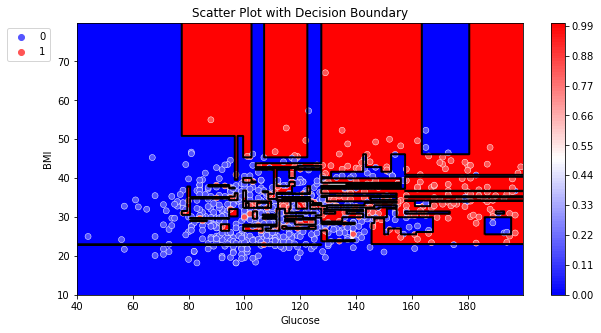

In [ ]:
plot_probabilities_2d(X, y, dt_clf_bad)

Перед нами типичная картина переобучения дерева решений. Дерево решений разделило пространство на огромное количество отдельных частей, чтобы обозначить все точки из обучающего набора данных правильным классом (уменьшить энтропию до нуля).

Конечно же, такая модель не имеет никакой обобщающей способности и никому не нужна.

**Важно!**

> Всегда используйте регуляризацию деревьев — ограничивайте их максимальную глубину (`max_depth`) и минимальное число объектов в листе (`min_samples_leaf`).

> К тому же всегда стоит иметь под рукой не только обучающий, но и тестовый набор данных, чтобы оценить переобучение. Об этом мы поговорим в финальном практическом юните.


Давайте попробуем обучить дерево решений на всех признаках. Принцип остаётся тем же, меняется только матрица наблюдений `X`:

In [ ]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

Будем использовать дерево решений с максимальной глубиной 6 (мы подобрали её заранее, при такой максимальной глубине наблюдается наименьшее переобучение).

Обучим модель на всех признаках с помощью метода `fit()`, затем сделаем предсказание с помощью метода `predict()` и выведем отчёт о метриках классификации с помощью функции `classification_report()`:

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X, y)

#Делаем предсказание класса
y_pred = dt_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       493
           1       0.84      0.69      0.76       264

    accuracy                           0.85       757
   macro avg       0.84      0.81      0.82       757
weighted avg       0.84      0.85      0.84       757



Метрики значительно улучшились по сравнению с обучением на двух признаках.

Напоследок расскажем о ещё одной полезной особенности дерева решений — оно позволяет определить важность признаков.

Важность признаков можно посмотреть, обратившись к атрибуту `feature_importance_`:

In [ ]:
print(dt_clf_full.feature_importances_)

[0.02675774 0.36675873 0.03368236 0.04553664 0.24588118 0.14137465
 0.14000868]


Значения, которые будут выведены в качестве элементов массива, — и есть коэффициенты важности каждого из признаков. Для удобства обычно строят столбчатую диаграмму:

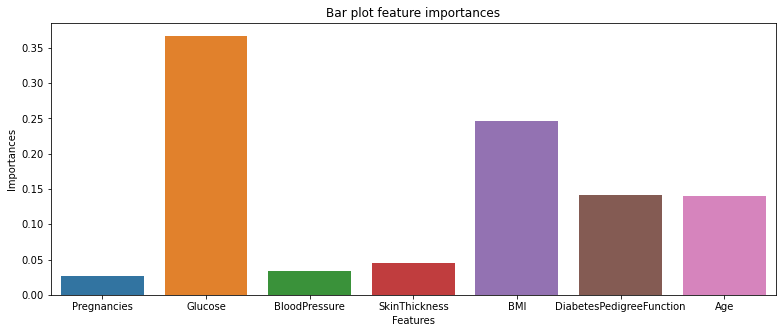

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = dt_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Далее эту информацию можно использовать для интерпретации значимости каждого из признаков для предсказания.

> Часто «древесные» модели используются в качестве методов отбора наиболее важных признаков. Это важно, когда в наборе данных большое количество признаков, из-за которых обучение более сложных моделей может стать очень длительным. 

> Кроме того, значимость признаков можно использовать в рамках анализа бизнес-процессов. Значимость позволяет понять, на какие признаки стоит обратить наибольшее внимание, чтобы повысить, например, точность их измерения.

> **Примечание**. Не стоит приравнивать значимость к корреляции. Корреляция — это коэффициент линейной зависимости, а значимость может отражать и нелинейные связи (в зависимости от сложности дерева).